Drive: https://drive.google.com/drive/folders/1nqlc7Zz92M5mj2NKjwUTwC8hOt9GLlIn?usp=sharing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import imageio
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from tqdm import tqdm

In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20, depth=2):
        super(VAE, self).__init__()

        input_dim = 784
        first_hidden = 512

        # Build encoder hidden dims: 512, 512/2, 512/4, ...
        hidden_dims = [first_hidden]
        curr = first_hidden
        for _ in range(depth - 1):   # we already added the first layer
            curr = max(curr // 2, latent_dim)
            hidden_dims.append(curr)

        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h))
            encoder_layers.append(nn.ReLU())
            prev_dim = h

        self.encoder = nn.Sequential(*encoder_layers)

        # Latent projections
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder mirror
        decoder_hidden = list(reversed(hidden_dims))

        decoder_layers = []
        prev_dim = latent_dim
        for h in decoder_hidden:
            decoder_layers.append(nn.Linear(prev_dim, h))
            decoder_layers.append(nn.ReLU())
            prev_dim = h

        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [3]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [4]:
def train_vae(model, train_loader, optimizer, epoch, beta=1.0):
    model.train()
    train_loss = 0
    total_bce = 0
    total_kld = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta)
        
        loss.backward()
        train_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()
        optimizer.step()
    
    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)
    
    return avg_loss, avg_bce, avg_kld

In [5]:
def calculate_fid(real_images, generated_images, inception_model, device='cuda'):
    inception_model.eval()
    
    def get_features(images, model):
        with torch.no_grad():
            images = F.interpolate(images, size=(299, 299), mode='bilinear')
            images = images.repeat(1, 3, 1, 1) if images.size(1) == 1 else images
            pred = model(images)
        return pred.cpu().numpy()
    
    real_features = get_features(real_images, inception_model)
    gen_features = get_features(generated_images, inception_model)
    
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
    
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [6]:
def testing_models(latent_dim, depth, beta, n_epocs, model_name):
    print(f"\nInitializing VAE with latent_dim={latent_dim}, depth={depth}")
    model = VAE(latent_dim=latent_dim, depth=depth).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    
    # ============= Training Loop =============
    print(f"\nTraining for {n_epochs} epochs with beta={beta}...")
    losses = {'total': [], 'bce': [], 'kld': []}
    
    for epoch in range(1, n_epochs + 1):
        avg_loss, avg_bce, avg_kld = train_vae(model, train_loader, optimizer, beta)
        
        losses['total'].append(avg_loss)
        losses['bce'].append(avg_bce)
        losses['kld'].append(avg_kld)
        
        print(f"Epoch {epoch:2d} | Loss: {avg_loss:.4f} | BCE: {avg_bce:.4f} | KLD: {avg_kld:.4f}")
    
    
    # ============= Visualization =============
    print("\nGenerating visualizations...")
    
    # 1. Loss Curves
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('VAE Training Curves (peketivenkata.v)', fontsize=14)
    
    axes[0].plot(losses['total'], 'b-', linewidth=2)
    axes[0].set_title('Total Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(losses['bce'], 'g-', linewidth=2)
    axes[1].set_title('Reconstruction Loss (BCE)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('BCE')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(losses['kld'], 'r-', linewidth=2)
    axes[2].set_title('KL Divergence')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('KLD')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('vae_training_curves.png', dpi=150, bbox_inches='tight')
    print("Saved: vae_training_curves.png")
    plt.show()
    
    
    # 2. Reconstruction Visualization
    model.eval()
    with torch.no_grad():
        # Get test batch
        test_data, _ = next(iter(test_loader))
        test_data = test_data.to(device)
        
        # Reconstruct
        recon, mu, logvar = model(test_data)
        recon = recon.view(-1, 28, 28)
        
        # Plot
        n_show = 10
        fig, axes = plt.subplots(2, n_show, figsize=(20, 4))
        fig.suptitle(f'Original vs Reconstructed Images (peketivenkata.v)', fontsize=14)
        
        for i in range(n_show):
            # Original
            axes[0, i].imshow(test_data[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original', fontsize=10)
            
            # Reconstructed
            axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed', fontsize=10)
        
        plt.tight_layout()
        plt.savefig('vae_reconstructions.png', dpi=150, bbox_inches='tight')
        print("Saved: vae_reconstructions.png")
        plt.show()
    
    
    # 3. Latent Space Visualization (2D projection if latent_dim > 2)
    print("\nComputing latent representations...")
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latents.append(mu.cpu().numpy())
            labels.append(label.numpy())
    
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    # Plot first 2 dimensions
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', 
                         alpha=0.6, s=1)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_title(f'Latent Space (first 2 dims) - All Classes (peketivenkata.v)')
    plt.colorbar(scatter, ax=ax, label='Class')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('vae_latent_space.png', dpi=150, bbox_inches='tight')
    print("Saved: vae_latent_space.png")
    plt.show()
    
    
    print("\n" + "="*50)
    print("Testing Complete!")
    print(f"Final Loss: {losses['total'][-1]:.4f}")
    print(f"Final BCE: {losses['bce'][-1]:.4f}")
    print(f"Final KLD: {losses['kld'][-1]:.4f}")
    print("="*50)


Using device: cuda
Loading Fashion-MNIST dataset...


100%|██████████| 26.4M/26.4M [00:03<00:00, 6.74MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 111kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 2.14MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.97MB/s]


Training samples: 60000
Test samples: 10000

Initializing VAE with latent_dim=2, depth=2

Total parameters: 1,068,820

Training for 10 epochs with beta=1...
Epoch  1 | Loss: 289.3420 | BCE: 283.0391 | KLD: 6.3030
Epoch  2 | Loss: 266.7725 | BCE: 260.4881 | KLD: 6.2843
Epoch  3 | Loss: 263.4566 | BCE: 257.1889 | KLD: 6.2677
Epoch  4 | Loss: 261.7824 | BCE: 255.4747 | KLD: 6.3077
Epoch  5 | Loss: 260.4242 | BCE: 254.0737 | KLD: 6.3506
Epoch  6 | Loss: 259.6942 | BCE: 253.3271 | KLD: 6.3671
Epoch  7 | Loss: 258.7753 | BCE: 252.3741 | KLD: 6.4012
Epoch  8 | Loss: 258.2487 | BCE: 251.8156 | KLD: 6.4331
Epoch  9 | Loss: 257.8876 | BCE: 251.4315 | KLD: 6.4561
Epoch 10 | Loss: 257.2479 | BCE: 250.7773 | KLD: 6.4706

Generating visualizations...
Saved: vae_training_curves.png


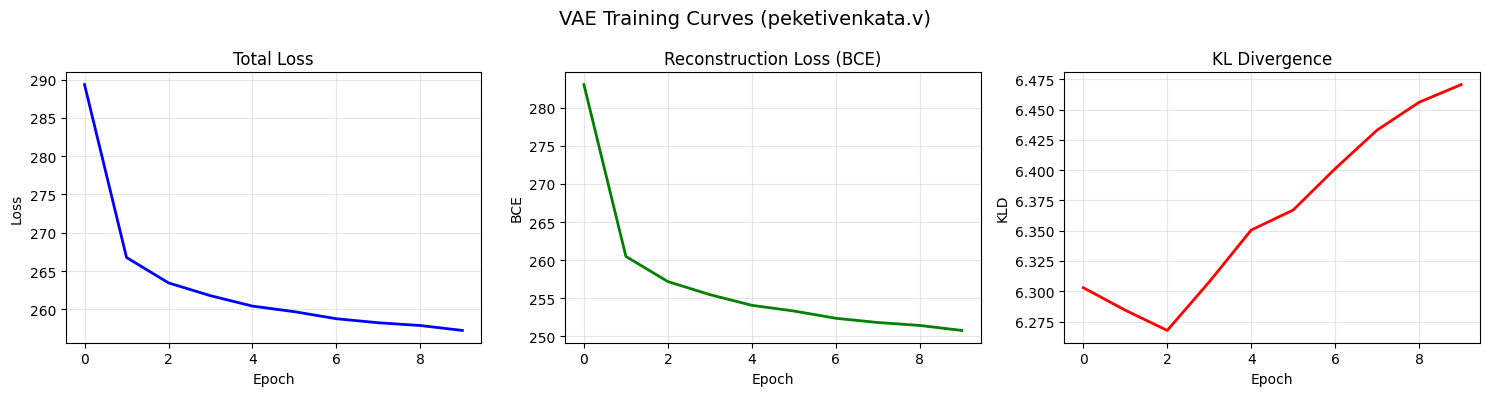

Saved: vae_reconstructions.png


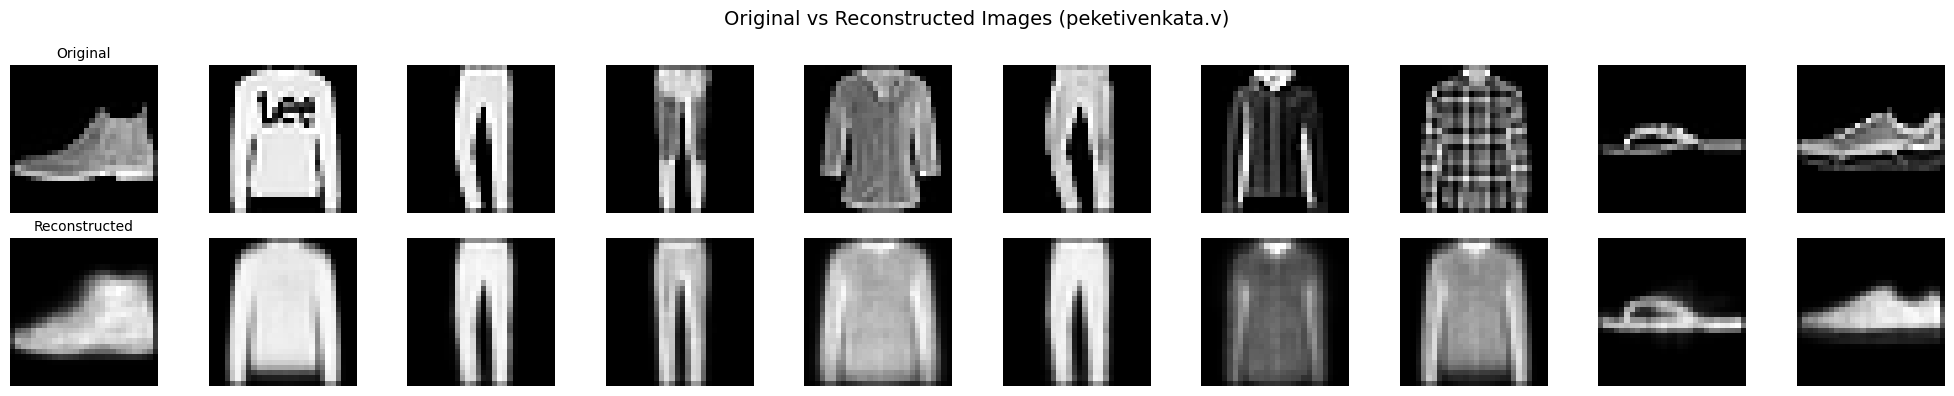


Computing latent representations...
Saved: vae_latent_space.png


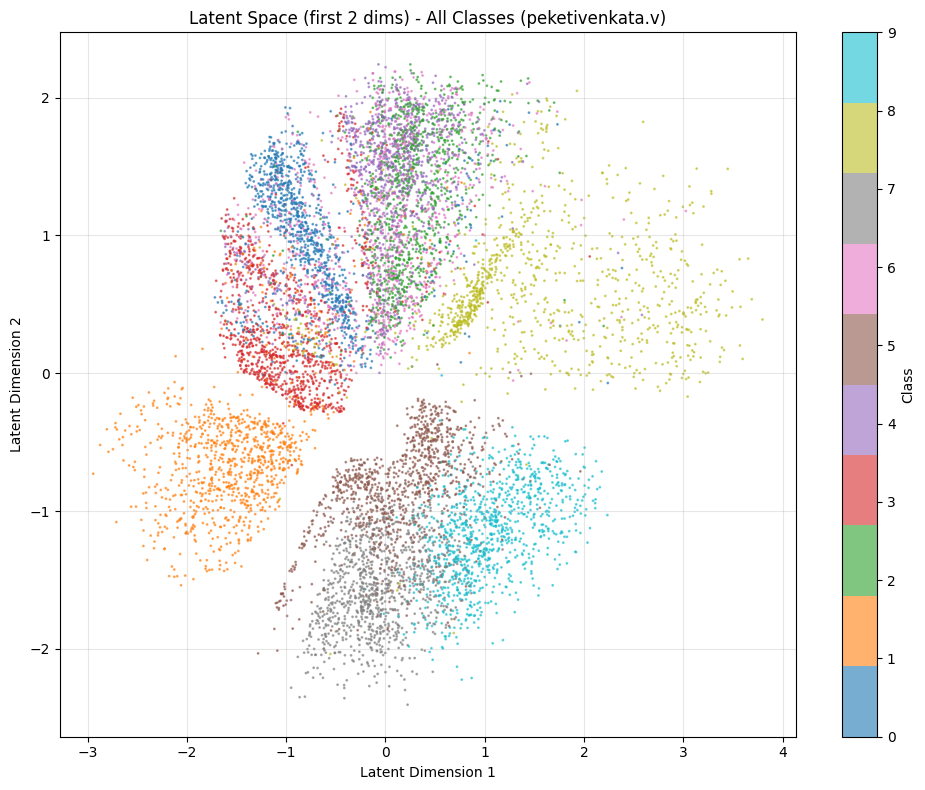


Testing Complete!
Final Loss: 257.2479
Final BCE: 250.7773
Final KLD: 6.4706


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Loading Fashion-MNIST dataset...")
transform = transforms.Compose([
    transforms.ToTensor(),  # Only convert to [0, 1], no normalization
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


# Model 1
latent_dim = 2
depth = 2
beta = 1
n_epochs = 10
model_name = 'Model1'

model_1 = testing_models(latent_dim, depth, beta, n_epochs, model_name)



Initializing VAE with latent_dim=2, depth=3

Total parameters: 1,133,844

Training for 10 epochs with beta=1...
Epoch  1 | Loss: 294.8388 | BCE: 288.9224 | KLD: 5.9164
Epoch  2 | Loss: 266.6814 | BCE: 260.4954 | KLD: 6.1860
Epoch  3 | Loss: 263.1929 | BCE: 256.9829 | KLD: 6.2100
Epoch  4 | Loss: 261.2963 | BCE: 255.0473 | KLD: 6.2490
Epoch  5 | Loss: 260.0856 | BCE: 253.8028 | KLD: 6.2828
Epoch  6 | Loss: 259.0508 | BCE: 252.7230 | KLD: 6.3278
Epoch  7 | Loss: 258.4021 | BCE: 251.9988 | KLD: 6.4033
Epoch  8 | Loss: 258.1985 | BCE: 251.7905 | KLD: 6.4081
Epoch  9 | Loss: 257.7046 | BCE: 251.2398 | KLD: 6.4648
Epoch 10 | Loss: 256.8438 | BCE: 250.3977 | KLD: 6.4461

Generating visualizations...
Saved: vae_training_curves.png


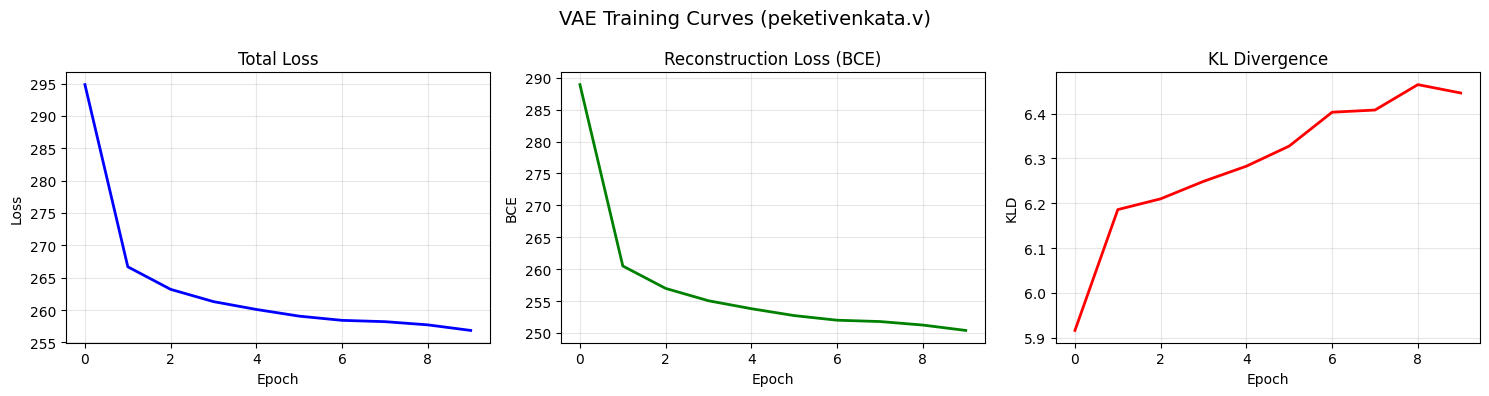

Saved: vae_reconstructions.png


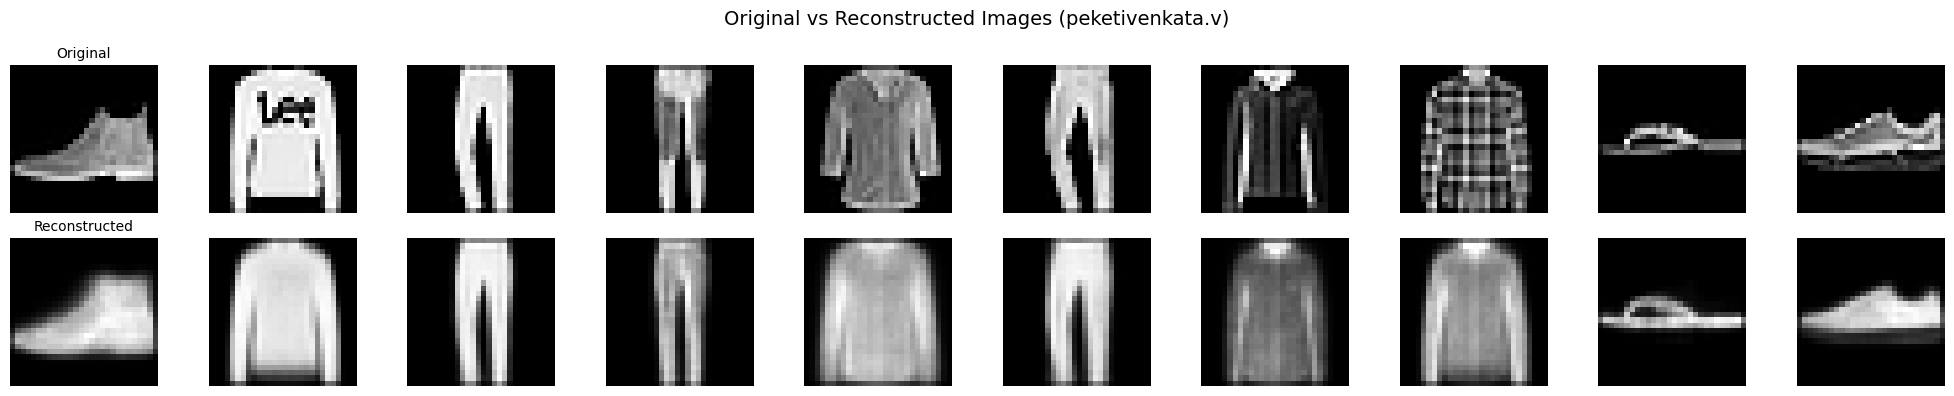


Computing latent representations...
Saved: vae_latent_space.png


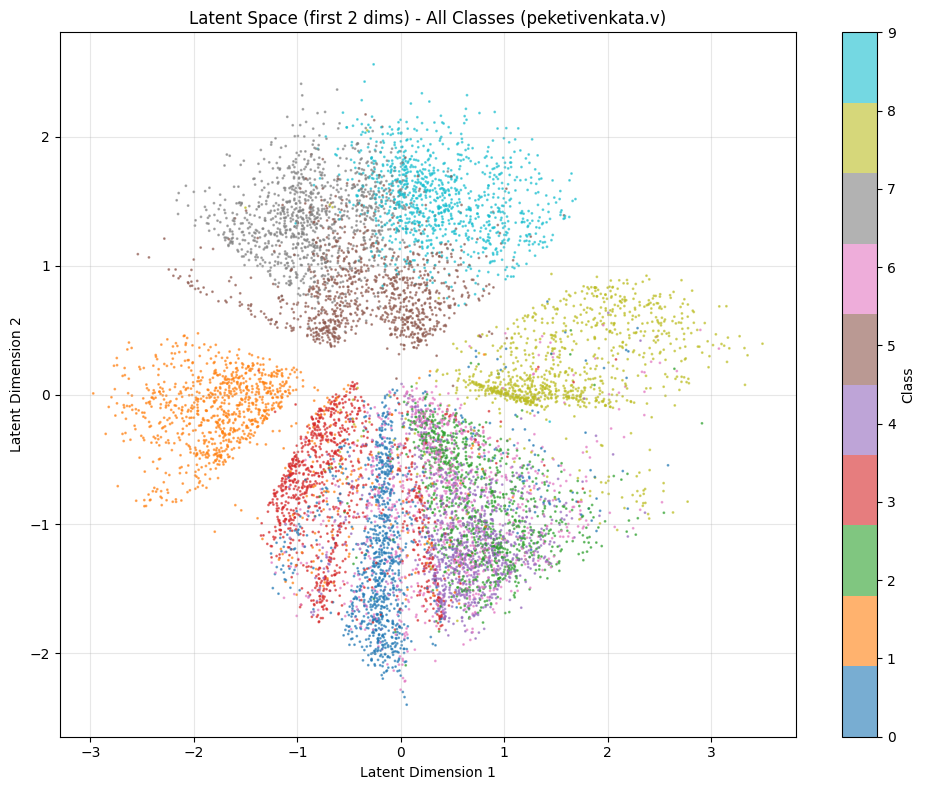


Testing Complete!
Final Loss: 256.8438
Final BCE: 250.3977
Final KLD: 6.4461


In [8]:
# Model 2
latent_dim = 2
depth = 3
beta = 1
n_epochs = 10
model_name = 'Model2'

model_2 = testing_models(latent_dim, depth, beta, n_epochs, model_name)


Initializing VAE with latent_dim=20, depth=3

Total parameters: 1,140,792

Training for 10 epochs with beta=1...
Epoch  1 | Loss: 297.4539 | BCE: 289.1987 | KLD: 8.2552
Epoch  2 | Loss: 257.5543 | BCE: 248.7402 | KLD: 8.8141
Epoch  3 | Loss: 251.4716 | BCE: 242.4835 | KLD: 8.9881
Epoch  4 | Loss: 248.6541 | BCE: 239.5859 | KLD: 9.0682
Epoch  5 | Loss: 247.1318 | BCE: 237.9644 | KLD: 9.1674
Epoch  6 | Loss: 246.1425 | BCE: 236.8762 | KLD: 9.2662
Epoch  7 | Loss: 245.3881 | BCE: 236.0653 | KLD: 9.3228
Epoch  8 | Loss: 244.7803 | BCE: 235.3989 | KLD: 9.3814
Epoch  9 | Loss: 244.2732 | BCE: 234.8499 | KLD: 9.4233
Epoch 10 | Loss: 243.8936 | BCE: 234.4256 | KLD: 9.4679

Generating visualizations...
Saved: vae_training_curves.png


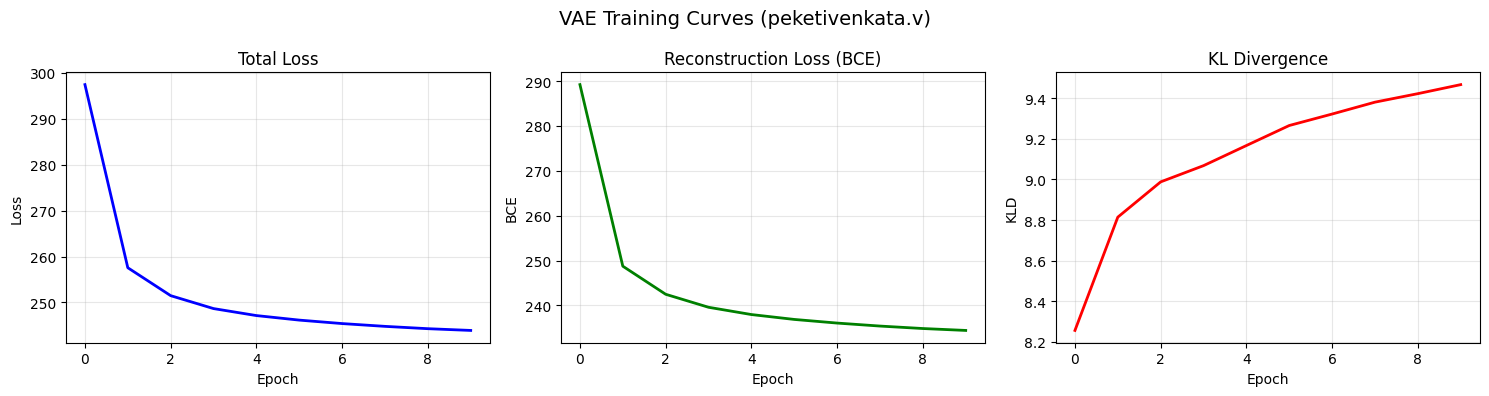

Saved: vae_reconstructions.png


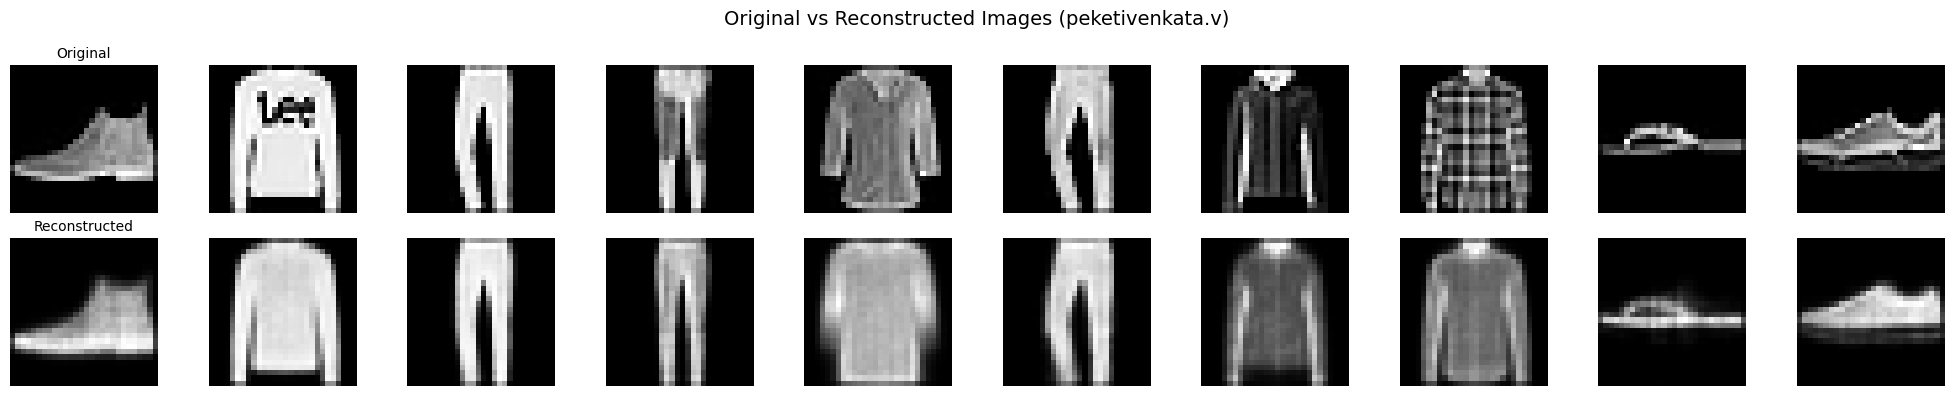


Computing latent representations...
Saved: vae_latent_space.png


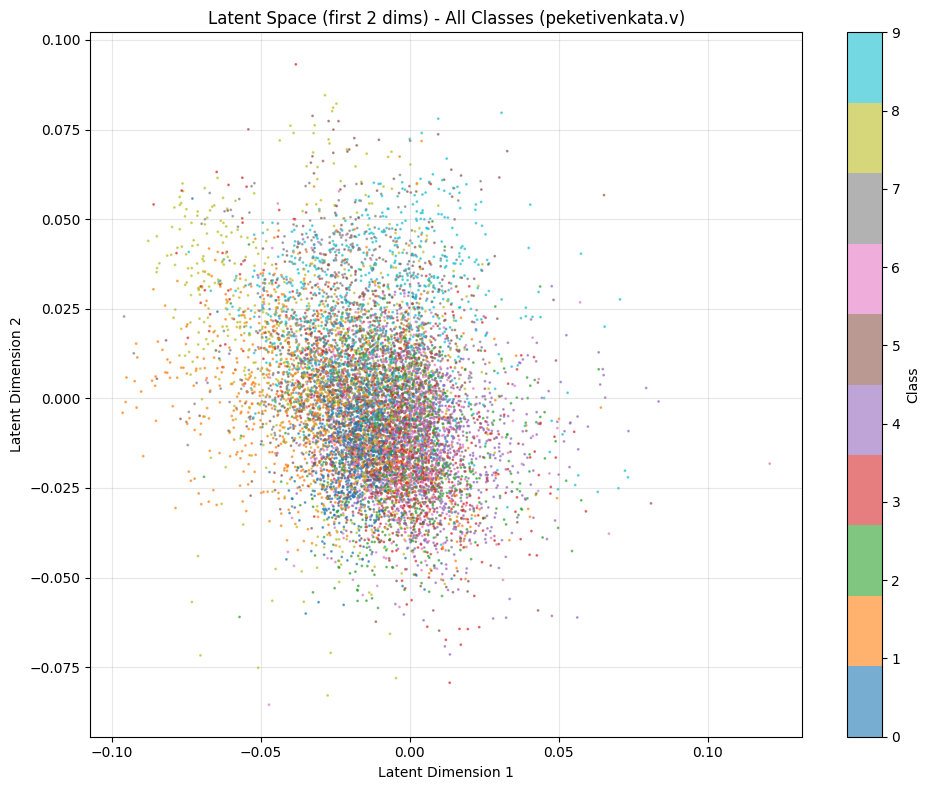


Testing Complete!
Final Loss: 243.8936
Final BCE: 234.4256
Final KLD: 9.4679


In [9]:
# Model 3
latent_dim = 20
depth = 3
beta = 1
n_epochs = 10
model_name = 'Model2'

model_3 = testing_models(latent_dim, depth, beta, n_epochs, model_name)


Training with β = 0.1
Epoch 5, Loss: 253.8844, BCE: 252.8259, KLD: 10.5849
Epoch 10, Loss: 250.5008, BCE: 249.4956, KLD: 10.0517
Epoch 15, Loss: 248.7301, BCE: 247.7394, KLD: 9.9075
Epoch 20, Loss: 247.3822, BCE: 246.3968, KLD: 9.8540


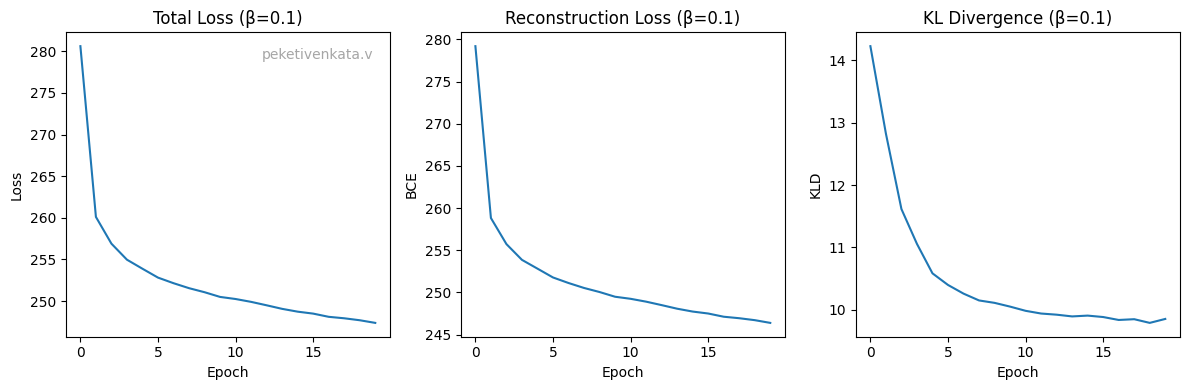


Training with β = 0.5
Epoch 5, Loss: 256.5720, BCE: 252.8853, KLD: 7.3734
Epoch 10, Loss: 253.0444, BCE: 249.3524, KLD: 7.3839
Epoch 15, Loss: 251.1969, BCE: 247.4600, KLD: 7.4738
Epoch 20, Loss: 250.5975, BCE: 246.8184, KLD: 7.5582


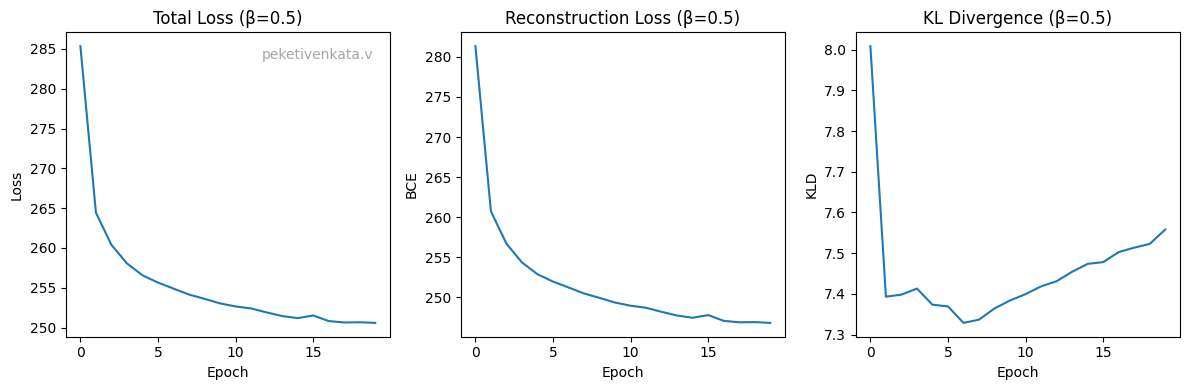


Training with β = 1.0
Epoch 5, Loss: 261.2697, BCE: 254.9908, KLD: 6.2789
Epoch 10, Loss: 257.4367, BCE: 251.0199, KLD: 6.4168
Epoch 15, Loss: 255.7856, BCE: 249.2112, KLD: 6.5744
Epoch 20, Loss: 254.4026, BCE: 247.7410, KLD: 6.6616


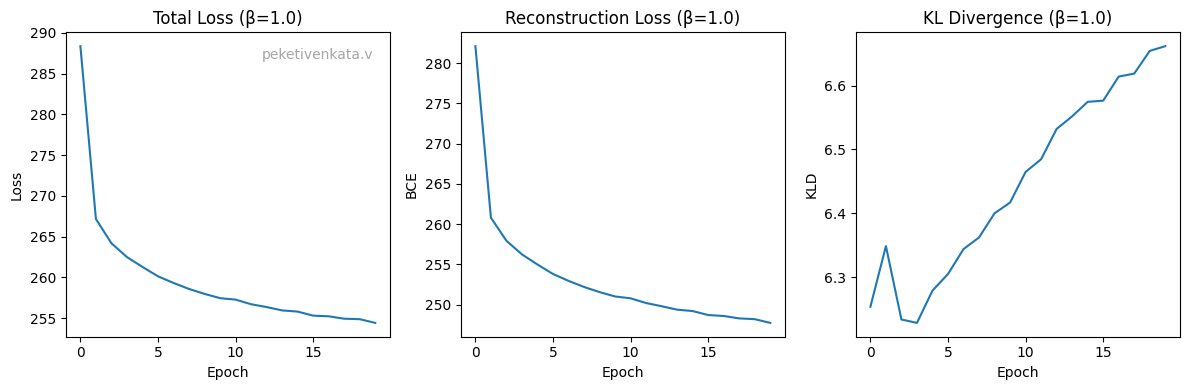

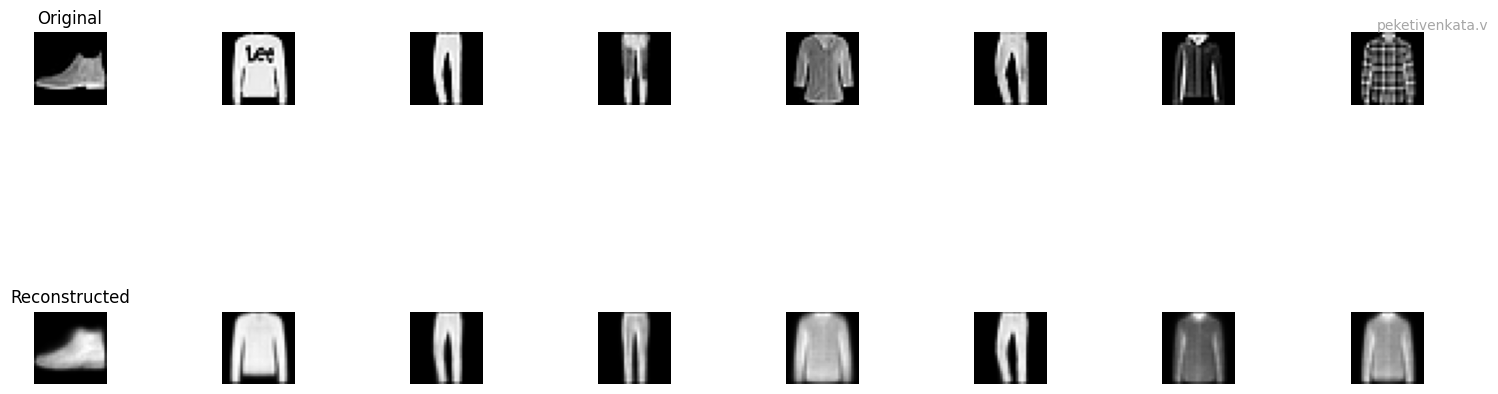

/tmp/ipykernel_48/1722847352.py:96: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


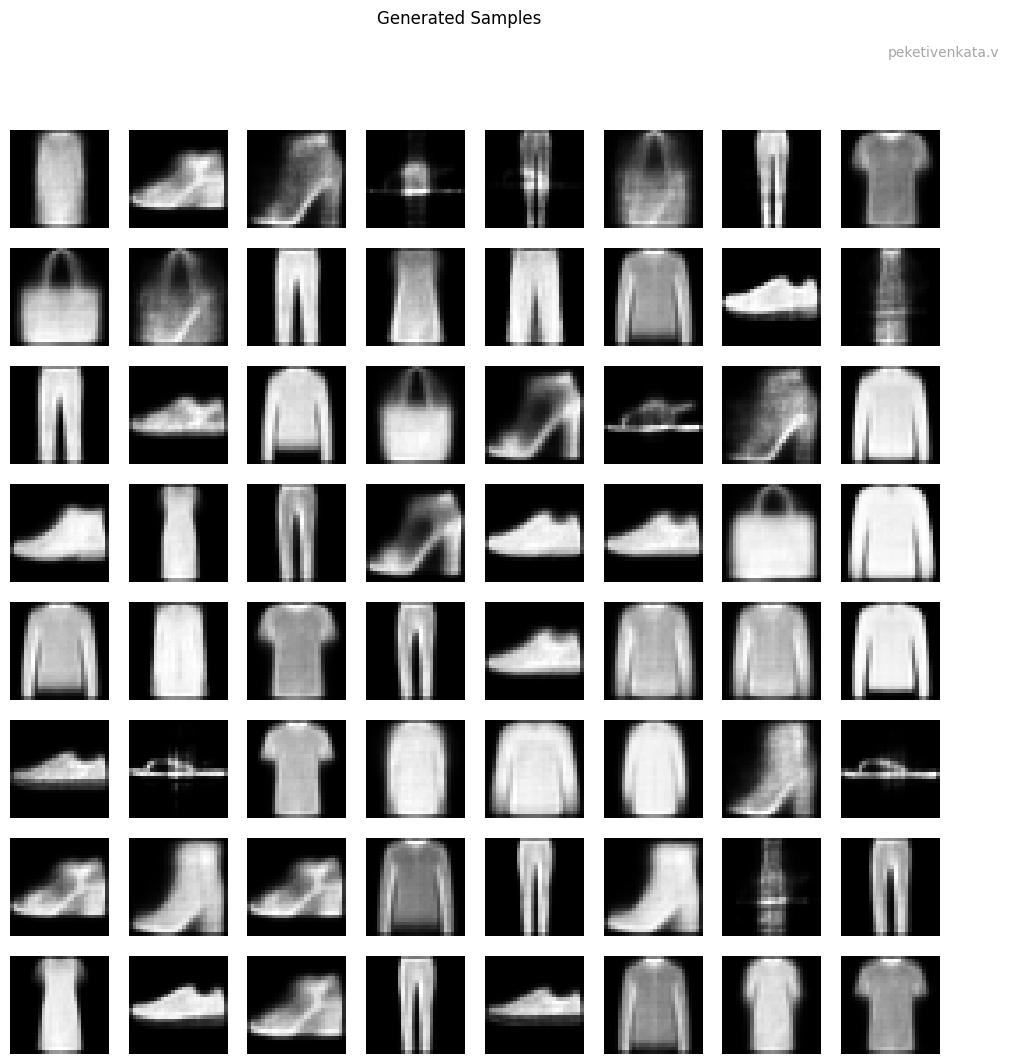

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 233MB/s] 


FID Score: 141.3203

Generating samples with frozen μ=0, σ=0.1


/tmp/ipykernel_48/1722847352.py:130: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


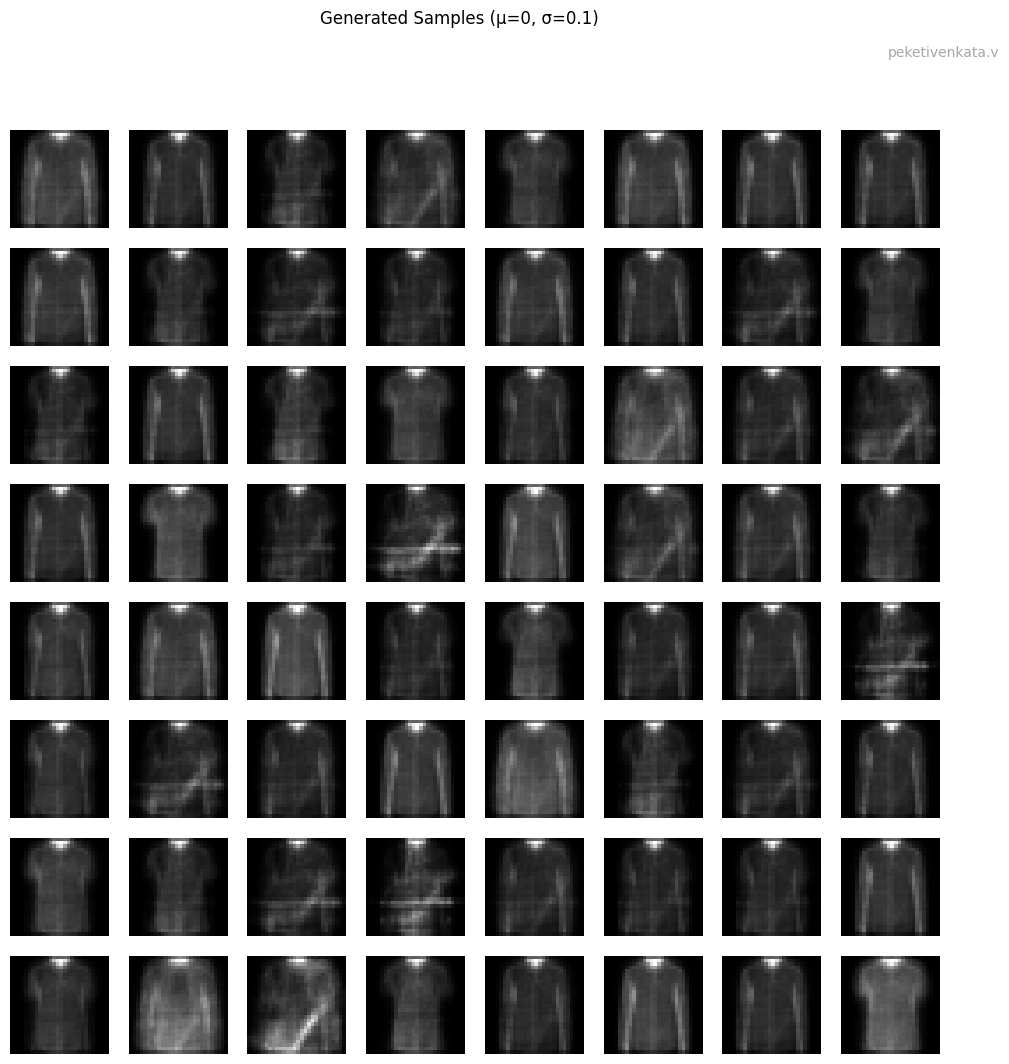


Generating samples with frozen μ=0, σ=0.5


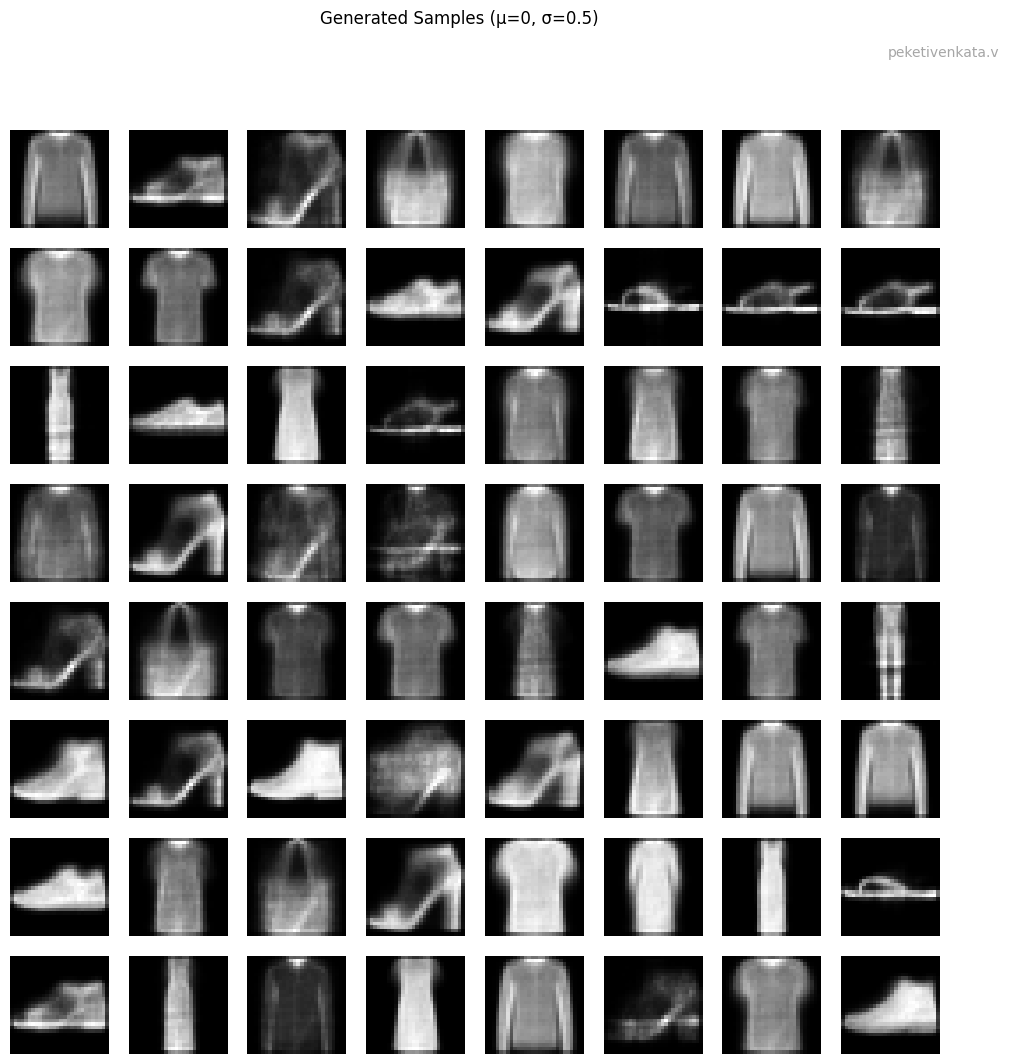


Generating samples with frozen μ=0, σ=1.0


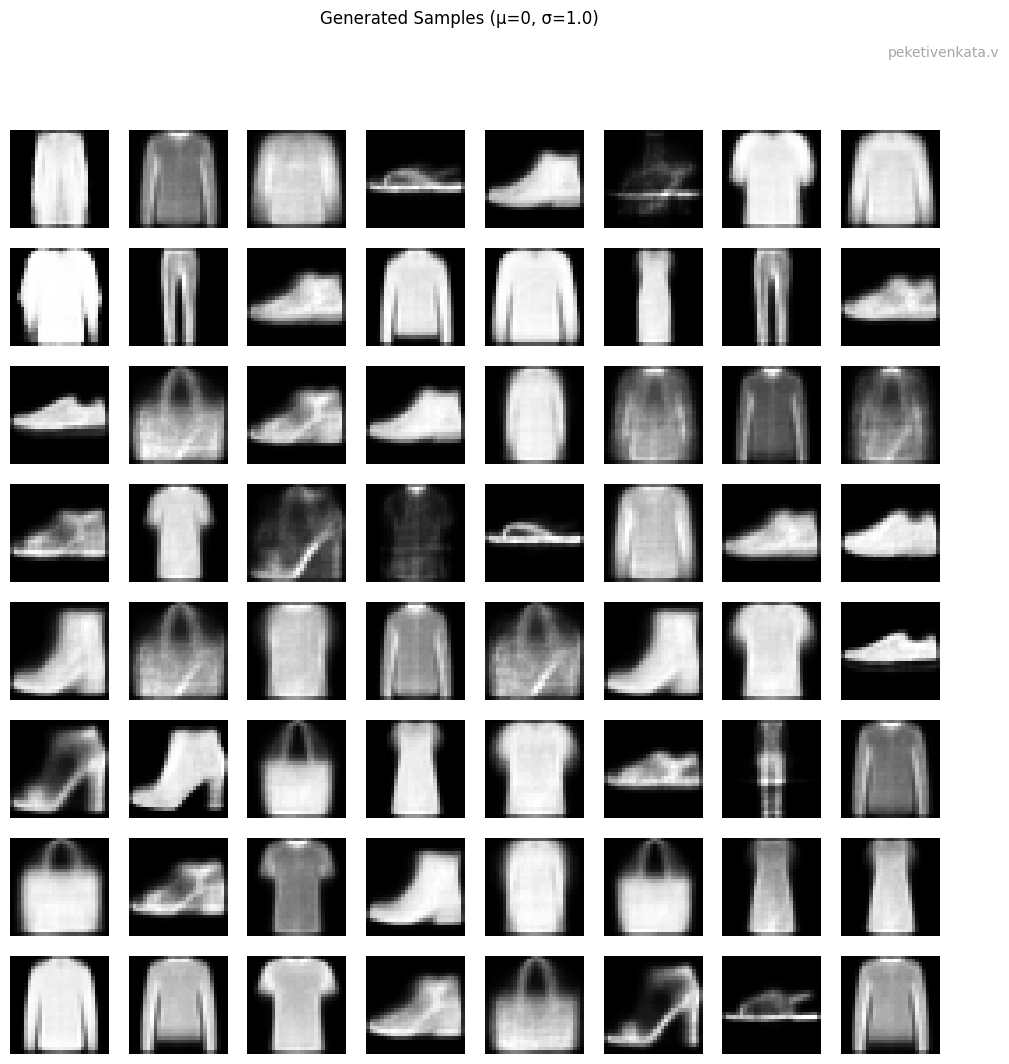


Comparison Summary:
Beta       Final BCE       Final KLD       Total Loss     
0.1        246.3968        9.8540          247.3822       
0.5        246.8184        7.5582          250.5975       
1.0        247.7410        6.6616          254.4026       


In [11]:
latent_dim = 2
num_epochs = 20
username = 'peketivenkata.v'

betas = [0.1, 0.5, 1.0]
results = {}

for beta in betas:
    print(f"\nTraining with β = {beta}")
    
    model = VAE(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    losses = {'total': [], 'bce': [], 'kld': []}
    
    for epoch in range(1, num_epochs + 1):
        avg_loss, avg_bce, avg_kld = train_vae(model, train_loader, optimizer, epoch, beta)
        losses['total'].append(avg_loss)
        losses['bce'].append(avg_bce)
        losses['kld'].append(avg_kld)
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')
    
    results[beta] = {'model': model, 'losses': losses}
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(losses['total'])
    plt.title(f'Total Loss (β={beta})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.text(0.95, 0.95, username, ha='right', va='top',
             transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
    
    plt.subplot(1, 3, 2)
    plt.plot(losses['bce'])
    plt.title(f'Reconstruction Loss (β={beta})')
    plt.xlabel('Epoch')
    plt.ylabel('BCE')
    
    plt.subplot(1, 3, 3)
    plt.plot(losses['kld'])
    plt.title(f'KL Divergence (β={beta})')
    plt.xlabel('Epoch')
    plt.ylabel('KLD')
    
    plt.tight_layout()
    plt.savefig(f'loss_curves_beta_{beta}_{username}.png')
    plt.show()

for beta in betas:
    model = results[beta]['model']
    # frames = create_latent_space_video(model, test_loader, beta, num_epochs, username, device)
    # imageio.mimsave(f'latent_evolution_beta_{beta}_{username}.gif', frames, fps=5)
    # print(f"Saved GIF for β={beta}")

model = results[1.0]['model']
model.eval()

with torch.no_grad():
    test_data = next(iter(test_loader))[0][:8].to(device)
    recon, _, _ = model(test_data)
    
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(test_data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')
        
        axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')
    
    plt.text(0.95, 0.95, username, ha='right', va='top',
             transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'reconstruction_{username}.png')
    plt.show()

with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decode(z).cpu()
    
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(samples[i*8+j].view(28, 28), cmap='gray')
            axes[i, j].axis('off')
    
    plt.text(0.95, 0.95, username, ha='right', va='top',
             transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
    plt.suptitle('Generated Samples')
    plt.tight_layout()
    plt.savefig(f'generated_samples_{username}.png')
    plt.show()

inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.fc = nn.Identity()

real_images = next(iter(test_loader))[0][:100].to(device)
with torch.no_grad():
    z = torch.randn(100, latent_dim).to(device)
    gen_images = model.decode(z).view(-1, 1, 28, 28)

fid_score = calculate_fid(real_images, gen_images, inception_model, device)
print(f"FID Score: {fid_score:.4f}")

sigmas = [0.1, 0.5, 1.0]
frozen_results = {}

for sigma in sigmas:
    print(f"\nGenerating samples with frozen μ=0, σ={sigma}")
    
    with torch.no_grad():
        z = torch.randn(64, latent_dim).to(device) * sigma
        samples = model.decode(z).cpu()
        
        fig, axes = plt.subplots(8, 8, figsize=(12, 12))
        for i in range(8):
            for j in range(8):
                axes[i, j].imshow(samples[i*8+j].view(28, 28), cmap='gray')
                axes[i, j].axis('off')
        
        plt.text(0.95, 0.95, username, ha='right', va='top',
                 transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
        plt.suptitle(f'Generated Samples (μ=0, σ={sigma})')
        plt.tight_layout()
        plt.savefig(f'frozen_samples_sigma_{sigma}_{username}.png')
        plt.show()
        
        frozen_results[sigma] = samples

print("\nComparison Summary:")
print(f"{'Beta':<10} {'Final BCE':<15} {'Final KLD':<15} {'Total Loss':<15}")
for beta in betas:
    losses = results[beta]['losses']
    print(f"{beta:<10} {losses['bce'][-1]:<15.4f} {losses['kld'][-1]:<15.4f} {losses['total'][-1]:<15.4f}")


In [12]:
def get_latent_representations(model, data_loader, classes=[0, 2, 4], device='cuda'):
    """Get latent representations for specific classes"""
    model.eval()
    latents = []
    labels = []
    images = []
    
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            
            for i, l in enumerate(label):
                if l.item() in classes:
                    latents.append(mu[i].cpu().numpy())
                    labels.append(l.item())
                    images.append(data[i].cpu())
    
    return np.array(latents), np.array(labels), images


def plot_latent_space_with_colors(latents, labels, images, epoch, batch, total_batches, beta, username='peketivenkata.v'):
    """Plot latent space with color-coded background points by class"""
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='black')
    ax.set_facecolor('black')
    
    # Define colors for each class
    class_colors = {0: 'red', 2: 'green', 4: 'blue'}
    
    # Plot all points color-coded by class in background
    for class_label in [0, 2, 4]:
        mask = labels == class_label
        if mask.any():
            ax.scatter(latents[mask, 0], latents[mask, 1], 
                      c=class_colors[class_label], s=1, alpha=0.3, 
                      label=f'Class {class_label}')
    
    # Sample and display images
    sample_indices = np.random.choice(len(latents), min(50, len(latents)), replace=False)
    
    for idx in sample_indices:
        img = images[idx].squeeze().numpy()
        imagebox = plt.matplotlib.offsetbox.OffsetImage(img, zoom=0.5, cmap='gray')
        ab = plt.matplotlib.offsetbox.AnnotationBbox(
            imagebox, (latents[idx, 0], latents[idx, 1]),
            frameon=True, pad=0.1, boxcoords="data"
        )
        ax.add_artist(ab)
    
    ax.set_xlabel('Latent Dimension 1', color='white')
    ax.set_ylabel('Latent Dimension 2', color='white')
    
    # Update title to show batch progress
    if epoch == 0 and batch == 0:
        title = f'Pre-training (3 classes)'
    else:
        title = f'3-class | Epoch {epoch}/{total_batches//len(train_loader)} | Batch {batch}/{total_batches}'
    
    ax.set_title(title, color='white', fontsize=14)
    ax.tick_params(colors='white')
    
    # Add legend for classes
    ax.legend(loc='upper right', fontsize=8, framealpha=0.3)
    
    plt.text(0.95, 0.95, username, ha='right', va='top',
             transform=ax.transAxes, fontsize=10, color='gray', alpha=0.7)
    plt.tight_layout()
    
    return fig


def train_vae_with_visualization(model, train_loader, test_loader, optimizer, num_epochs, beta, 
                                 username='peketivenkata.v', device='cuda', 
                                 visualize_every_n_batches=10, classes=[0, 2, 4]):
    """
    Train VAE and create video frames at batch intervals
    """
    frames = []
    batch_count = 0
    total_batches = len(train_loader) * num_epochs
    
    # Create pre-training frame (noise)
    print("Creating pre-training frame...")
    latents, labels, images = get_latent_representations(model, test_loader, classes=classes, device=device)
    fig = plot_latent_space_with_colors(latents, labels, images, 0, 0, total_batches, beta, username)
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    plt.close(fig)
    
    # Training loop with batch-level visualization
    for epoch in range(1, num_epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}')
        
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta)
            
            loss.backward()
            optimizer.step()
            
            batch_count += 1
            
            pbar.set_postfix({
                'loss': f'{loss.item()/len(data):.4f}',
                'bce': f'{bce.item()/len(data):.4f}',
                'kld': f'{kld.item()/len(data):.4f}'
            })
            
            # Visualize every N batches
            if batch_idx % visualize_every_n_batches == 0:
                latents, labels, images = get_latent_representations(
                    model, test_loader, classes=classes, device=device
                )
                fig = plot_latent_space_with_colors(
                    latents, labels, images, epoch, batch_count, total_batches, beta, username
                )
                
                fig.canvas.draw()
                image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(image)
                plt.close(fig)
    
    return frames

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Loading Fashion-MNIST dataset...")
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Parameters
latent_dim = 2
num_epochs = 5  # Adjust as needed
username = 'peketivenkata.v'
classes_to_visualize = [1, 4, 9]  # Choose your 3 classes

betas = [0.1, 0.5, 1.0]

for beta in betas:
    print(f"\n{'='*50}")
    print(f"Training with β = {beta}")
    print(f"{'='*50}")
    
    model = VAE(latent_dim=latent_dim, depth=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    frames = train_vae_with_visualization(
        model, train_loader, test_loader, optimizer, 
        num_epochs, beta, username, device,
        visualize_every_n_batches=30,  
        classes=classes_to_visualize
    )
    
    # Save as GIF
    output_filename = f'latent_evolution_beta_{beta}_{username}.gif'
    imageio.mimsave(output_filename, frames, fps=5)
    print(f"\nSaved: {output_filename}")
    print(f"Total frames: {len(frames)}")

Using device: cuda
Loading Fashion-MNIST dataset...

Training with β = 0.1
Creating pre-training frame...


Epoch 5/5: 100%|██████████| 469/469 [00:35<00:00, 13.20it/s, loss=228.2857, bce=227.2289, kld=10.5675]



Saved: latent_evolution_beta_0.1_peketivenkata.v.gif
Total frames: 81

Training with β = 0.5
Creating pre-training frame...


Epoch 5/5: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s, loss=262.2223, bce=258.5034, kld=7.4380]



Saved: latent_evolution_beta_0.5_peketivenkata.v.gif
Total frames: 81

Training with β = 1.0
Creating pre-training frame...


Epoch 5/5: 100%|██████████| 469/469 [00:30<00:00, 15.19it/s, loss=267.4278, bce=260.7759, kld=6.6519]



Saved: latent_evolution_beta_1.0_peketivenkata.v.gif
Total frames: 81
